<a href="https://www.kaggle.com/code/anannoasif/digit-recognizer-using-cnn?scriptVersionId=157419291" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import DataLoader, TensorDataset

%matplotlib inline

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
train = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
train

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
test = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')
test

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
sample = pd.read_csv('/kaggle/input/digit-recognizer/sample_submission.csv')
sample

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
27995,27996,0
27996,27997,0
27997,27998,0
27998,27999,0


In [6]:
X_train = train.drop('label', axis=1).values.reshape(-1, 1, 28, 28) / 255.0
y_train = train.label.values
X_test = test.values.reshape(-1, 1, 28, 28) / 255.0


In [7]:
X_train.shape
X_test.shape

(28000, 1, 28, 28)

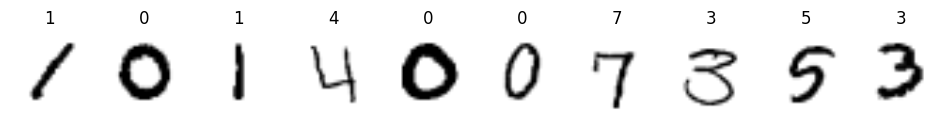

In [8]:
fig, ax = plt.subplots(1, 10, figsize=(12, 8))

for i in range(10):
    digit = X_train[i].reshape(28, 28)
    ax[i].imshow(digit, cmap=plt.cm.binary, interpolation='bilinear')
    ax[i].set_axis_off()
    ax[i].set_title(y_train[i])

plt.show()

In [9]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Create DataLoader for the training data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create DataLoader for the test data
test_loader = DataLoader(X_test_tensor, batch_size=32, shuffle=True)

In [10]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)

torch.Size([42000, 1, 28, 28])
torch.Size([28000, 1, 28, 28])


In [11]:
# Define the Neural Network model for digit recognition
class DigitRecognizerNN(nn.Module):
    def __init__(self):
        super(DigitRecognizerNN, self).__init__()
        
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 64, kernel_size=3, padding=1)  
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  
        self.bn3 = nn.BatchNorm2d(128)
        
        
        # Max pooling layer
        self.pool = nn.MaxPool2d(2, 2, padding=1)

        # Dropout layers
        self.dropout1 = nn.Dropout(0.75)
        self.dropout2 = nn.Dropout(0.625)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 5 * 5, 64)  # Input size after max pooling
        self.fc2 = nn.Linear(64, 10)  # Output layer for 10 classes

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.bn1(self.conv1(x))))  # Convolution, BatchNorm, Leakyleaky_relu, Pooling
        x = self.pool(F.leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(F.leaky_relu(self.bn3(self.conv3(x))))
        # print(x.shape)
        x = x.view(x.size(0), -1)  # Flatten the tensor for fully connected layers
        
        # Apply dropout
        x = self.dropout1(x)
        
        # Fully connected layers with Leakyleaky_relu activations
        x = F.leaky_relu(self.fc1(x))
        x = self.dropout2(x)
        
        # Output layer without activation (to be handled by loss function)
        x = F.softmax(self.fc2(x))
        return x

# Instantiate the model and move it to the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Choose device based on availability
model = DigitRecognizerNN().to(device)  # Move the model to the chosen device


In [12]:
# Loss Function
loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8, weight_decay=0.000025)
# Learning Rate Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [13]:
def train(dataloader, model, loss_fn, optimizer, device):
    # Get the total size of the dataset
    size = len(dataloader.dataset)
    # Set the model in training mode
    model.train()
    # Initialize variables to track loss and accuracy
    running_loss = 0.0
    correct = 0
    total = 0

    # Create a progress bar using tqdm to visualize training progress
    with tqdm(total=len(dataloader), desc="Training", unit="batch") as pbar:
        # Iterate through each batch in the dataloader
        for batch, (X, y) in enumerate(dataloader):
            # Move data to the specified device (GPU or CPU)
            X, y = X.to(device), y.to(device)

            # Zero the gradients to prepare for backpropagation
            optimizer.zero_grad()
            # Forward pass: compute predictions
            pred = model(X)
            # Calculate the loss
            loss = loss_fn(pred, y)
            # Backpropagation: compute gradients
            loss.backward()
            # Update model parameters using the optimizer
            optimizer.step()

            # Update running loss
            running_loss += loss.item()
            # Calculate predicted labels by finding the index of the maximum value along dim=1
            predicted = torch.argmax(pred, dim=1)
            # Update total number of samples processed
            total += y.size(0)
            # Update number of correctly predicted samples
            correct += (predicted == y).sum().item()

            # Update the progress bar
            pbar.update(1)
            # Update displayed metrics in the progress bar
            pbar.set_postfix({'loss': running_loss / (batch + 1), 'accuracy': 100 * correct / total})

    # Calculate epoch-level loss and accuracy
    epoch_loss = running_loss / len(dataloader)
    epoch_acc = 100 * correct / size
    # Print epoch-level metrics
    print(f"End of Epoch: Avg loss: {epoch_loss:.8f}, Accuracy: {epoch_acc:.8f}%\n")


In [14]:
# Training loop
epochs = 10

# Loop through each epoch
for epoch in range(epochs):
    # Print the current epoch number
    print(f"Epoch {epoch + 1}")
    
    # Execute the training process for the current epoch
    train(train_loader, model, loss_fn, optimizer, device)
    
    # Update the learning rate using the scheduler after completing an epoch
    scheduler.step()
    
# Once all epochs are completed, print the end of training message
print("End of training. Saving model...")

# Save the trained model's state dictionary to a file named "model.pth"
torch.save(model.state_dict(), "model.pth")


Epoch 1


Training:   0%|          | 0/1313 [00:00<?, ?batch/s]/tmp/ipykernel_26/692722312.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))
Training: 100%|██████████| 1313/1313 [00:17<00:00, 73.00batch/s, loss=1.99, accuracy=49.7] 


End of Epoch: Avg loss: 1.99226461, Accuracy: 49.72857143%

Epoch 2


Training: 100%|██████████| 1313/1313 [00:06<00:00, 199.92batch/s, loss=1.69, accuracy=79.9]


End of Epoch: Avg loss: 1.69143072, Accuracy: 79.87142857%

Epoch 3


Training: 100%|██████████| 1313/1313 [00:06<00:00, 196.50batch/s, loss=1.6, accuracy=87.9]


End of Epoch: Avg loss: 1.60461458, Accuracy: 87.93333333%

Epoch 4


Training: 100%|██████████| 1313/1313 [00:06<00:00, 203.99batch/s, loss=1.57, accuracy=90.5]


End of Epoch: Avg loss: 1.57257571, Accuracy: 90.52857143%

Epoch 5


Training: 100%|██████████| 1313/1313 [00:06<00:00, 197.42batch/s, loss=1.56, accuracy=91.7]


End of Epoch: Avg loss: 1.55735538, Accuracy: 91.66904762%

Epoch 6


Training: 100%|██████████| 1313/1313 [00:06<00:00, 196.95batch/s, loss=1.55, accuracy=92.5]


End of Epoch: Avg loss: 1.54883505, Accuracy: 92.45952381%

Epoch 7


Training: 100%|██████████| 1313/1313 [00:06<00:00, 199.88batch/s, loss=1.54, accuracy=92.8]


End of Epoch: Avg loss: 1.54450773, Accuracy: 92.76666667%

Epoch 8


Training: 100%|██████████| 1313/1313 [00:06<00:00, 199.73batch/s, loss=1.55, accuracy=92.7]


End of Epoch: Avg loss: 1.54547884, Accuracy: 92.72380952%

Epoch 9


Training: 100%|██████████| 1313/1313 [00:06<00:00, 200.71batch/s, loss=1.54, accuracy=92.8]


End of Epoch: Avg loss: 1.54377155, Accuracy: 92.83095238%

Epoch 10


Training: 100%|██████████| 1313/1313 [00:06<00:00, 201.90batch/s, loss=1.54, accuracy=93.1]


End of Epoch: Avg loss: 1.54236789, Accuracy: 93.06904762%

End of training. Saving model...


In [15]:
# Set the model to evaluation mode
model.eval()

# List to store predicted labels
predictions = []

# Disable gradient calculation since we're only predicting
with torch.no_grad():
    # Iterate through the test data loader
    for data in test_loader:
        # Move input data to the same device as the model
        data = data.to(device)

        # Get predictions from the model
        outputs = model(data)
        # Extract the predicted labels by finding the index of the maximum value
        _, predicted = torch.max(outputs.data, 1)
        # Extend the predictions list with the predicted labels (move to CPU if necessary)
        predictions.extend(predicted.cpu().tolist())

# Create a DataFrame for submission with ImageId and predicted labels
submission = pd.DataFrame({
    "ImageId": range(1, len(predictions) + 1),  # ImageId starts from 1
    "Label": predictions  # Predicted labels
})

# Save the submission DataFrame to a CSV file named 'digits.csv' without including the index
submission.to_csv('digits.csv', index=False)


/tmp/ipykernel_26/692722312.py:41: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.fc2(x))
